Импортируем требуемые библиотеки.

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from torchvision.utils import draw_bounding_boxes, draw_keypoints
import torch.nn.functional as F

Загружаем предобученную модель.

In [2]:
model =  torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 128MB/s]


Загружаем картинку модели, с которой будем сравнивать все остальные.

In [3]:
model_image = plt.imread('/content/dspr_cv_u1_diploma_spr1_3_1.png')

In [4]:
model_image.shape

(886, 1300, 4)

In [5]:
# Четырехканальную картинку преобразуем в трехканальную
model_image = model_image[...,:3]

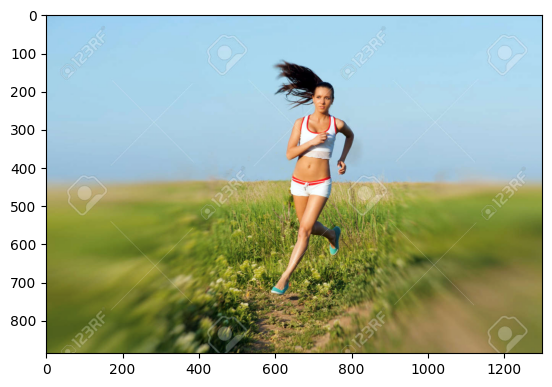

In [6]:
plt.imshow(model_image)

In [7]:
model_image.shape

(886, 1300, 3)

In [8]:
# Преобразуем массив в тензор
transform = torchvision.transforms.Compose([T.ToTensor()])
model_image_tensor = transform(model_image)

In [9]:
model_image_tensor.shape

torch.Size([3, 886, 1300])

Получим результат работы модели

In [10]:
model.eval()
model_out = model([model_image_tensor])

Посмотрим на выход модели

In [11]:
len(model_out)

1

In [12]:
model_out

[{'boxes': tensor([[589.0520, 164.7326, 804.7424, 745.0168],
          [496.4900, 396.0956, 524.9801, 433.9450]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1]),
  'scores': tensor([0.9997, 0.1649], grad_fn=<IndexBackward0>),
  'keypoints': tensor([[[724.5498, 228.4089,   1.0000],
           [736.7170, 218.4422,   1.0000],
           [715.7010, 217.3347,   1.0000],
           [751.0963, 226.1940,   1.0000],
           [700.2155, 218.4422,   1.0000],
           [762.1574, 287.1017,   1.0000],
           [665.9263, 285.9943,   1.0000],
           [795.3405, 319.2167,   1.0000],
           [639.3798, 363.5132,   1.0000],
           [778.7490, 381.2318,   1.0000],
           [700.2155, 334.7205,   1.0000],
           [720.1254, 447.6766,   1.0000],
           [661.5018, 445.4617,   1.0000],
           [676.9873, 567.2771,   1.0000],
           [685.8362, 567.2771,   1.0000],
           [631.6370, 682.4481,   1.0000],
           [748.8842, 578.3513,   1.0000]],
  
          [[515.666

In [13]:
model_out = model_out[0]

In [14]:
torch.tensor(np.vstack((model_out['boxes'][0].detach().numpy(), model_out['boxes'][1].detach().numpy())))

tensor([[589.0520, 164.7326, 804.7424, 745.0168],
        [496.4900, 396.0956, 524.9801, 433.9450]])

Отрисуем boundbox'ы

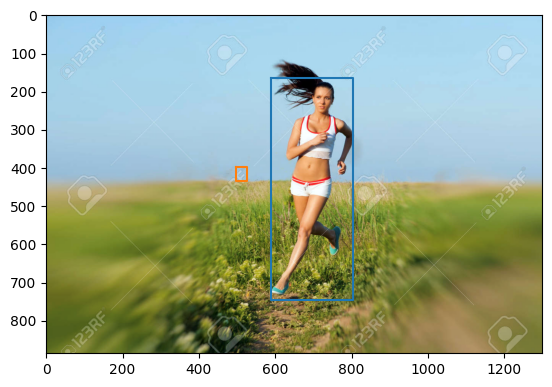

In [15]:
plt.imshow(model_image_tensor.permute(1, 2, 0))
for i in range(len(model_out['boxes'])):
  x1 = model_out['boxes'][i][0].item()
  x2 = model_out['boxes'][i][2].item()
  y1 = model_out['boxes'][i][1].item()
  y2 = model_out['boxes'][i][3].item()
  x = [x1, x2, x2, x1, x1]
  y = [y1, y1, y2, y2, y1]
  plt.plot(x,y)

In [16]:
model_image_tensor_255 = model_image_tensor * 255
model_bounding_boxes = draw_bounding_boxes(model_image_tensor_255.to(torch.uint8), model_out['boxes'], colors = ["blue", "yellow"], width=5)

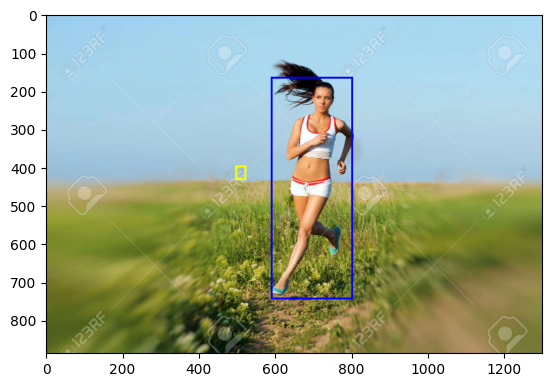

In [17]:
plt.imshow(model_bounding_boxes.permute(1, 2, 0))

Отрисуем ключевые точки

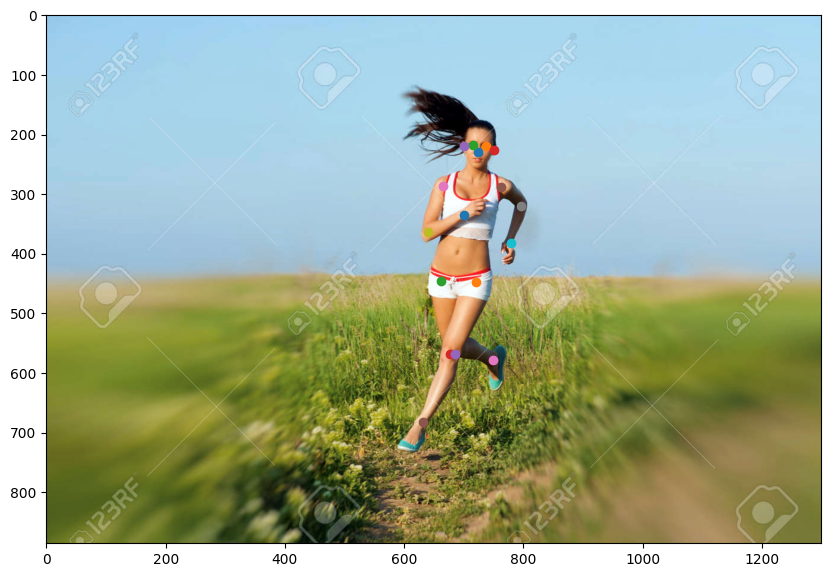

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(model_image_tensor.permute(1, 2, 0))
for i in range(len(model_out['keypoints'][0])):
  x = model_out['keypoints'][0][i][0].item()
  y = model_out['keypoints'][0][i][1].item()
  plt.scatter(x,y)

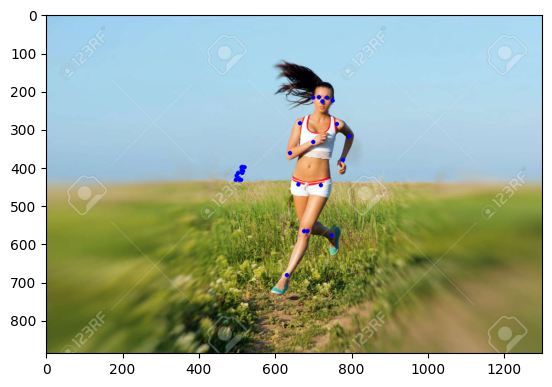

In [19]:
model_keypoints = draw_keypoints(model_image_tensor_255.to(torch.uint8), model_out['keypoints'], colors = "blue", radius=5,)
plt.imshow(model_keypoints.permute(1, 2, 0))

Напишем функцию отрисовки ключевых точек

In [20]:
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [21]:
def draw_keypoints_per_person(
    img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9
):
    # создаём спектр цветов
    cmap = plt.get_cmap("rainbow")
    # создаём копию изображений
    img_copy = img.copy()
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]
    # для каждого задетектированного человека
    for person_id in range(len(all_keypoints)):
        # проверяем степень уверенности детектора
        if confs[person_id] > conf_threshold:
            # собираем ключевые точки конкретного человека
            keypoints = all_keypoints[person_id, ...]
            # собираем скоры для ключевых точек
            scores = all_scores[person_id, ...]
            # итерируем по каждому скору
            for kp in range(len(scores)):
                # проверяем степень уверенности детектора опорной точки
                if scores[kp] > keypoint_threshold:
                    # конвертируем массив ключевых точек в список целых чисел
                    keypoint = tuple(
                        map(int, keypoints[kp, :2].detach().numpy().tolist())
                    )
                    # выбираем цвет
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)
                    # рисуем кружок радиуса 5 вокруг точки
                    cv2.circle(img_copy, keypoint, 5, color, -1)

    return img_copy

In [22]:
model_keypoints_img = draw_keypoints_per_person(model_image, model_out["keypoints"], model_out["keypoints_scores"], model_out["scores"], keypoint_threshold=2)

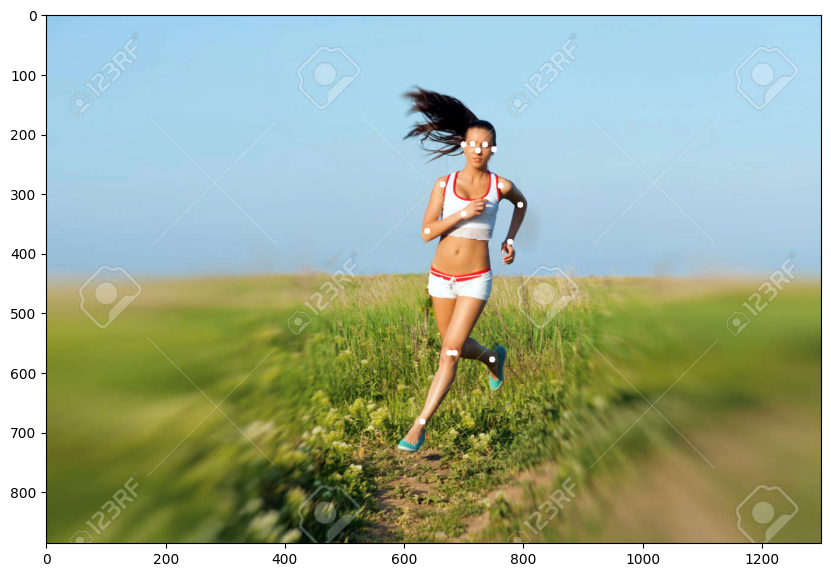

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(model_keypoints_img)

Напишем функцию отрисовки скелета

In [24]:
def get_limbs_from_keypoints(keypoints):
    limbs = [
        [keypoints.index("right_eye"), keypoints.index("nose")],
        [keypoints.index("right_eye"), keypoints.index("right_ear")],
        [keypoints.index("left_eye"), keypoints.index("nose")],
        [keypoints.index("left_eye"), keypoints.index("left_ear")],
        [keypoints.index("right_shoulder"), keypoints.index("right_elbow")],
        [keypoints.index("right_elbow"), keypoints.index("right_wrist")],
        [keypoints.index("left_shoulder"), keypoints.index("left_elbow")],
        [keypoints.index("left_elbow"), keypoints.index("left_wrist")],
        [keypoints.index("right_hip"), keypoints.index("right_knee")],
        [keypoints.index("right_knee"), keypoints.index("right_ankle")],
        [keypoints.index("left_hip"), keypoints.index("left_knee")],
        [keypoints.index("left_knee"), keypoints.index("left_ankle")],
        [keypoints.index("right_shoulder"), keypoints.index("left_shoulder")],
        [keypoints.index("right_hip"), keypoints.index("left_hip")],
        [keypoints.index("right_shoulder"), keypoints.index("right_hip")],
        [keypoints.index("left_shoulder"), keypoints.index("left_hip")],
    ]
    return limbs

In [25]:
limbs = get_limbs_from_keypoints(keypoints)

In [26]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):

    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(all_keypoints)>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # iterate for every limb
            for limb_id in range(len(limbs)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 5)

    return img_copy

In [27]:
model_skeletal_img = draw_skeleton_per_person(model_image, model_out["keypoints"], model_out["keypoints_scores"], model_out["scores"],keypoint_threshold=2)

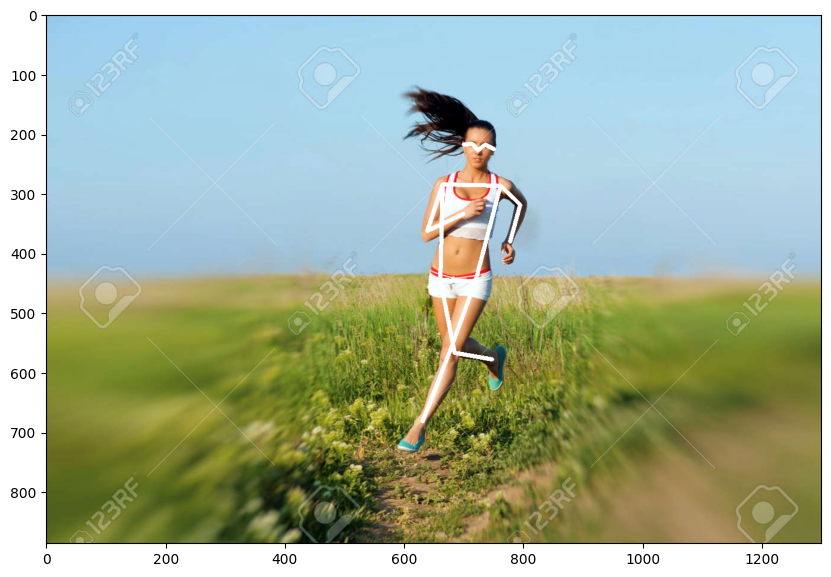

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(model_skeletal_img)

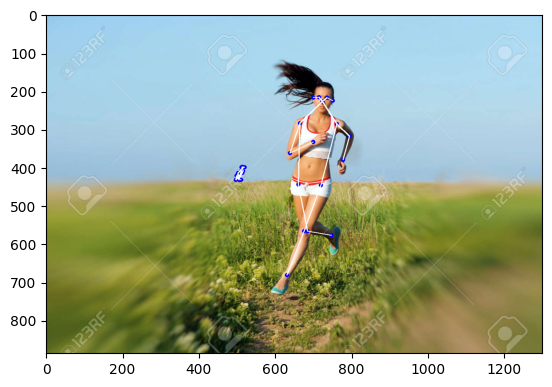

In [29]:
connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)
]
model_skeleton = draw_keypoints(model_image_tensor_255.to(torch.uint8), model_out['keypoints'], connectivity=connect_skeleton, colors = "blue", radius=5, width=3)
plt.imshow(model_skeleton.permute(1, 2, 0))

Для сравнения картинок приведем требуемое изображение к изображению модели

Соберём два набора ключевых точек

model_key_points = [[x1,y2],[x2,y2],...]

input_key_points = [[x1,y2],[x2,y2],...]

С помощью расширенной матрицы можно осуществить умножение вектора x на матрицу

 A и добавление вектора b за счёт единственного матричного умножения.

Расширенная матрица создаётся путём дополнения векторов "1" в конце.

pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])

unpad = lambda x: x[:, :-1]

Расширим наборы ключевых точек до [[ x y 1] , [x y 1]]

Y = pad(model_key_points)

X = pad(input_key_points)

Решим задачу наименьших квадратов X * A = Y

и найдём матрицу аффинного преобразования A.

A, res, rank, s = np.linalg.lstsq(X, Y)

A[np.abs(A) < 1e-10] = 0  # превратим в "0" слишком маленькие значения

Теперь, когда мы нашли расширенную матрицу A,

мы можем преобразовать входной набор ключевых точек

transform = lambda x: unpad(np.dot(pad(x), A))

input_transform = transform(input_key_points)

Напишем функции для расчета метрик, косинусное расстояние и взвешенное расстояние

In [30]:
def cosine_distance(train_pose, model_pose):
    cossin = train_pose.dot(np.transpose(model_pose)) / (
        np.linalg.norm(train_pose) * np.linalg.norm(model_pose)
    )
    dist = cossin

    return dist


def weight_distance(train_pose, model_pose, train_conf):
    # D(U,V) = (1 / sum(conf1)) * sum(conf1 * ||train_pose - model_pose||) = sum1 * sum2

    sum1 = 1 / np.sum(train_conf)
    sum2 = 0

    for i in range(len(train_pose)):
        # каждый индекс i имеет x и y, у которых одинаковая оценка достоверности
        #conf_ind = math.floor(i / 2)
        sum2 += train_conf[i] * abs(train_pose[i] - model_pose[i])

    weighted_dist = sum1 * sum2

    return weighted_dist

Сравним несколько изображений с исходным

In [31]:
train_image1 = plt.imread('/content/runer.jpeg')

In [32]:
train_image1.shape

(422, 750, 3)

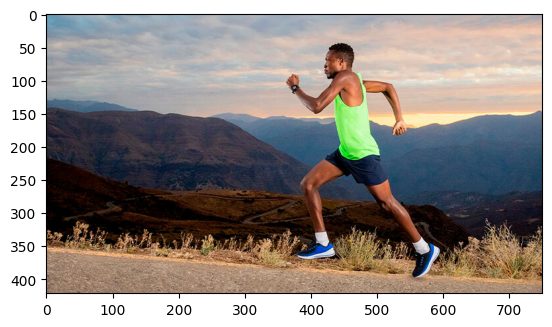

In [33]:
plt.imshow(train_image1)

In [34]:
train_image_tensor1 = transform(train_image1)
train_out1 = model([train_image_tensor1])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [35]:
train_out1 = train_out1[0]
train_keypoints_img1 = draw_keypoints_per_person(train_image1, train_out1["keypoints"], train_out1["keypoints_scores"], train_out1["scores"], keypoint_threshold=2)

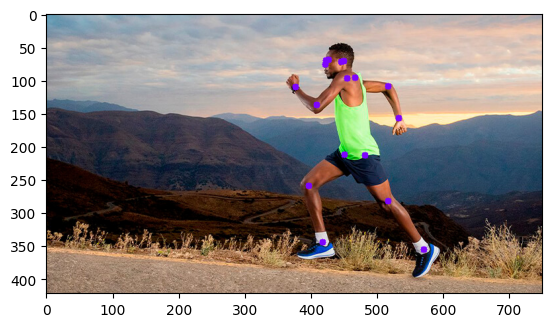

In [36]:
plt.imshow(train_keypoints_img1)

In [37]:
train_skeletal_img1 = draw_skeleton_per_person(train_image1, train_out1["keypoints"], train_out1["keypoints_scores"], train_out1["scores"],keypoint_threshold=2)

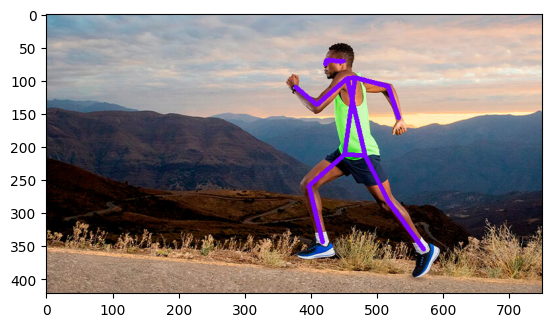

In [38]:
plt.imshow(train_skeletal_img1)

In [39]:
model_key_points = model_out["keypoints"][0][:,:2]
train_key_points1 = train_out1["keypoints"][0][:,:2]

In [40]:
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:, :-1]

In [41]:
Y = pad(model_key_points.detach().numpy())
X = pad(train_key_points1.detach().numpy())

In [42]:
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0

<ipython-input-42-62e8c84a96ac>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


In [43]:
transform_unpad = lambda x: unpad(np.dot(pad(x), A))
train_key_points_transform1 = transform_unpad(train_key_points1.detach().numpy())

In [44]:
cd = cosine_distance(train_key_points_transform1, model_key_points.detach().numpy())

In [45]:
cd.shape

(17, 17)

In [46]:
display(cd)

array([[0.05196027, 0.05252976, 0.05114378, 0.05363163, 0.05016476,
        0.0556857 , 0.04942639, 0.05854086, 0.04940853, 0.05882758,
        0.05271796, 0.05648822, 0.05264126, 0.05631938, 0.05689271,
        0.05590994, 0.06122087],
       [0.0516199 , 0.0521955 , 0.05081466, 0.05328786, 0.04983779,
        0.05528755, 0.04904841, 0.05810858, 0.04896946, 0.05834549,
        0.05229141, 0.05596094, 0.05212758, 0.05569828, 0.05626984,
        0.05519925, 0.06057592],
       [0.05177922, 0.05235665, 0.05097153, 0.05345237, 0.04999162,
        0.05545797, 0.04919944, 0.05828761, 0.04911986, 0.05852495,
        0.05245228, 0.05613265, 0.05228739, 0.05586857, 0.05644191,
        0.05536742, 0.06076132],
       [0.05095453, 0.05151413, 0.05015452, 0.05259441, 0.04919396,
        0.05460402, 0.04846348, 0.05740216, 0.04843894, 0.05767782,
        0.05168825, 0.05537681, 0.05160297, 0.05520034, 0.05576281,
        0.05478825, 0.06000791],
       [0.05079522, 0.05135297, 0.04999765, 0.052429

Посмотрим на среднее значение косинусного расстояния

In [47]:
cd.mean()

0.05688832323163594

При нахождении косинусного расстояния матриц (17;2) мы получаем матрицу (17;17), где каждое значение представляют собой косинусное расстояние от каждой точки одного изображения с каждой точкой второго. Но нам нужны значения только идентичных точек, которые лежат на главной диагонали матрицы.

In [48]:
cd_diag = np.diag(cd)
cd_diag

array([0.05196027, 0.0521955 , 0.05097153, 0.05259441, 0.04904014,
       0.05514066, 0.04859742, 0.06134596, 0.04782353, 0.06213967,
       0.05203883, 0.06175903, 0.05904736, 0.06759132, 0.07052532,
       0.07503893, 0.08039271])

In [49]:
cd_diag.mean()

0.05871779857430218

Однако, если мы найдем косинусное расстояние матриц (2;17), то по главной диагонали будет находится коинусное рассояние по всем координатам X и Y всех точек.

In [50]:
cd_2 = cosine_distance(train_key_points_transform1.T, model_key_points.detach().numpy().T)
cd_2

array([[0.75869352, 0.3953095 ],
       [0.3953095 , 0.23950906]])

In [51]:
cd_2_diag = np.diag(cd_2)
print(cd_2_diag)
print(cd_2_diag.mean())

[0.75869352 0.23950906]
0.49910128788156854


In [52]:
wd = weight_distance(train_key_points_transform1, model_key_points.detach().numpy(), train_out1["keypoints_scores"].detach().numpy()[0])

In [53]:
wd

array([27.20009749, 28.72895577])

In [54]:
wd.mean()

27.964526629777716

Сравним с исходным изображением картинку, которая очень похожа на нее

In [55]:
train_image2 = plt.imread('/content/runer_train.jpg')
train_image2.shape

(1080, 1080, 3)

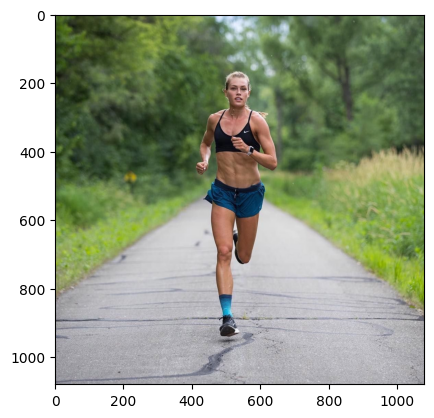

In [56]:
plt.imshow(train_image2)

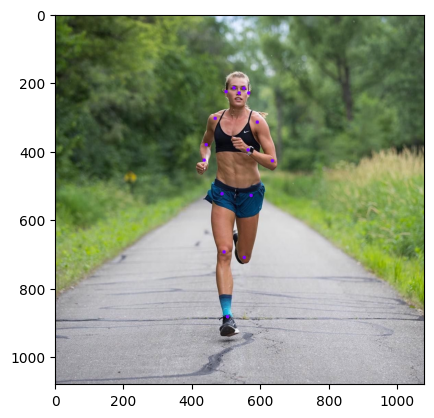

In [57]:
train_image_tensor2 = transform(train_image2)
train_out2 = model([train_image_tensor2])
train_out2 = train_out2[0]
train_keypoints_img2 = draw_keypoints_per_person(train_image2, train_out2["keypoints"], train_out2["keypoints_scores"], train_out2["scores"], keypoint_threshold=2)
plt.imshow(train_keypoints_img2)

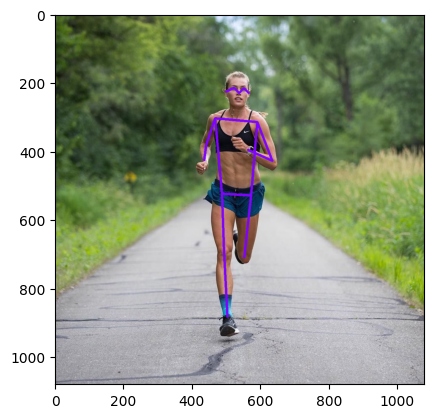

In [58]:
train_skeletal_img2 = draw_skeleton_per_person(train_image2, train_out2["keypoints"], train_out2["keypoints_scores"], train_out2["scores"],keypoint_threshold=2)
plt.imshow(train_skeletal_img2)

In [59]:
train_key_points2 = train_out2["keypoints"][0][:,:2]
X2 = pad(train_key_points2.detach().numpy())
A2, res, rank, s = np.linalg.lstsq(X2, Y)
A2[np.abs(A2) < 1e-10] = 0
transform_unpad2 = lambda x: unpad(np.dot(pad(x), A2))
train_key_points_transform2 = transform_unpad2(train_key_points2.detach().numpy())
cd2 = cosine_distance(train_key_points_transform2, model_key_points.detach().numpy())

<ipython-input-59-09c707c1f0c8>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A2, res, rank, s = np.linalg.lstsq(X2, Y)


In [60]:
cd2

array([[0.05102666, 0.05160002, 0.0502333 , 0.05267881, 0.04926575,
        0.05463727, 0.04846055, 0.057419  , 0.04835522, 0.05763183,
        0.05165423, 0.0552477 , 0.05145323, 0.05494574, 0.05551162,
        0.05441132, 0.05977101],
       [0.05140019, 0.05199265, 0.05060997, 0.05307587, 0.04962888,
        0.05498668, 0.04873319, 0.0577654 , 0.04853437, 0.05790719,
        0.05190932, 0.05541393, 0.05157413, 0.05496597, 0.05553901,
        0.05428788, 0.05983908],
       [0.050272  , 0.05084327, 0.04949421, 0.05190462, 0.04853821,
        0.05380756, 0.04770866, 0.05653813, 0.04756517, 0.0567167 ,
        0.05083757, 0.05432856, 0.05058268, 0.05396945, 0.05452826,
        0.05338305, 0.05872872],
       [0.05213922, 0.05273463, 0.0513343 , 0.05383472, 0.05034151,
        0.05579615, 0.04946453, 0.05862355, 0.04929747, 0.05879448,
        0.0527016 , 0.05629961, 0.05241115, 0.05589889, 0.05647904,
        0.05526323, 0.06083739],
       [0.04949636, 0.0500429 , 0.04872102, 0.051091

In [61]:
cd2.mean()

0.05691499067752256

In [62]:
cd2_diag = np.diag(cd2)
print(cd2_diag)
print(cd2_diag.mean())

[0.05102666 0.05199265 0.04949421 0.05383472 0.04778667 0.05806484
 0.04710446 0.06488868 0.04818836 0.06210664 0.05139685 0.06397989
 0.05707407 0.07088301 0.06889665 0.07123186 0.07978467]
0.05869028642508775


In [63]:
cd2_2 = cosine_distance(train_key_points_transform2.T, model_key_points.detach().numpy().T)
print(cd2_2)
cd2_2_diag = np.diag(cd2_2)
print(cd2_2_diag)
print(cd2_2_diag.mean())

[[0.75932402 0.39641359]
 [0.39641359 0.23841085]]
[0.75932402 0.23841085]
0.4988674346132459


In [64]:
wd2 = weight_distance(train_key_points_transform2, model_key_points.detach().numpy(), train_out2["keypoints_scores"].detach().numpy()[0])

In [65]:
wd2

array([16.63176092, 16.53406356])

In [66]:
wd2.mean()

16.582912237410163

Взвешенное расстояние оказалось ожидаемо меньше.

А теперь сравним с картинкой, которая сильно отличается от модельной

In [67]:
train_image3 = plt.imread('/content/runer_false.jpg')
train_image3.shape

(960, 534, 3)

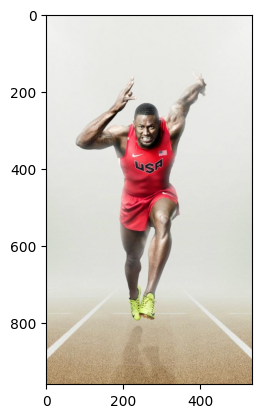

In [68]:
plt.imshow(train_image3)

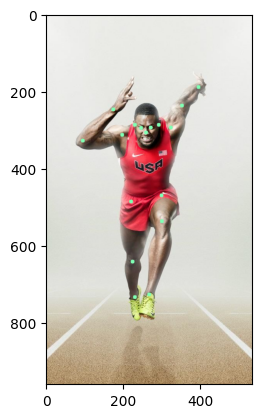

In [69]:
train_image_tensor3 = transform(train_image3)
train_out3 = model([train_image_tensor3])
train_out3 = train_out3[0]
train_keypoints_img3 = draw_keypoints_per_person(train_image3, train_out3["keypoints"], train_out3["keypoints_scores"], train_out3["scores"], keypoint_threshold=2)
plt.imshow(train_keypoints_img3)

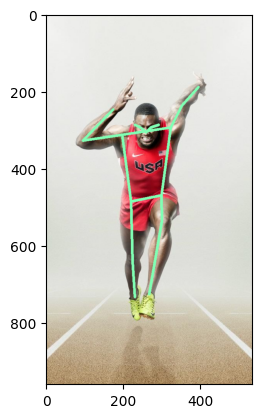

In [70]:
train_skeletal_img3 = draw_skeleton_per_person(train_image3, train_out3["keypoints"], train_out3["keypoints_scores"], train_out3["scores"],keypoint_threshold=2)
plt.imshow(train_skeletal_img3)

In [71]:
train_key_points3 = train_out3["keypoints"][0][:,:2]
X3 = pad(train_key_points3.detach().numpy())
A3, res, rank, s = np.linalg.lstsq(X3, Y)
A3[np.abs(A3) < 1e-10] = 0
transform_unpad3 = lambda x: unpad(np.dot(pad(x), A3))
train_key_points_transform3 = transform_unpad3(train_key_points3.detach().numpy())
cd3 = cosine_distance(train_key_points_transform3, model_key_points.detach().numpy())

<ipython-input-71-922fc4522e23>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A3, res, rank, s = np.linalg.lstsq(X3, Y)


In [72]:
cd3

array([[0.05220284, 0.05270404, 0.05133995, 0.05382761, 0.05038715,
        0.05618642, 0.05004813, 0.05916623, 0.05047168, 0.05979994,
        0.05354998, 0.05788621, 0.0541049 , 0.05840127, 0.05896294,
        0.05865542, 0.06326607],
       [0.05249675, 0.05301075, 0.05163499, 0.05413832, 0.0506725 ,
        0.05646891, 0.05027493, 0.05944984, 0.05063878, 0.06003851,
        0.05376909, 0.05805262, 0.05423826, 0.0584743 , 0.05904115,
        0.0586363 , 0.06337486],
       [0.05166145, 0.05216953, 0.05081476, 0.05327863, 0.0498666 ,
        0.05556273, 0.04946253, 0.05849269, 0.04980653, 0.05906099,
        0.05289488, 0.05709279, 0.05333646, 0.05748595, 0.05804424,
        0.05762418, 0.06231044],
       [0.05314454, 0.05366873, 0.05227446, 0.05480931, 0.05129842,
        0.05715265, 0.05087409, 0.06016433, 0.05121848, 0.06074151,
        0.0544008 , 0.05870744, 0.05484147, 0.05909717, 0.05967179,
        0.05922507, 0.06406144],
       [0.05101383, 0.05152447, 0.05018311, 0.052617

In [73]:
cd3.mean()

0.057007759741382794

In [74]:
cd3_diag = np.diag(cd3)
print(cd3_diag)
print(cd3_diag.mean())

[0.05220284 0.05301075 0.05081476 0.05480931 0.04924296 0.05840851
 0.04807351 0.06178786 0.04523283 0.06296865 0.04946489 0.06356323
 0.05716192 0.06780519 0.06871223 0.07651872 0.07633308]
0.05859477937562557


In [75]:
cd3_2 = cosine_distance(train_key_points_transform3.T, model_key_points.detach().numpy().T)
print(cd3_2)
cd3_2_diag = np.diag(cd3_2)
print(cd3_2_diag)
print(cd3_2_diag.mean())

[[0.76068696 0.39653692]
 [0.39653692 0.23542429]]
[0.76068696 0.23542429]
0.4980556246928173


In [76]:
wd3 = weight_distance(train_key_points_transform3, model_key_points.detach().numpy(), train_out3["keypoints_scores"].detach().numpy()[0])
wd3

array([17.6611895 , 58.62494799])

In [77]:
wd3.mean()

38.143068743892684

А вот здесь взвешенное расстояние ожидаемо больше, чем в первом случае.

Для контроля сравним модельное изображение с самим собой

In [78]:
model_key_points.detach().numpy() == model_key_points.detach().numpy()

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [79]:
cd_own = cosine_distance(model_key_points.detach().numpy(), model_key_points.detach().numpy())

In [80]:
cd_own

array([[0.05068959, 0.05126392, 0.04990433, 0.05233448, 0.04894111,
        0.05426021, 0.04811423, 0.05701611, 0.04798   , 0.05720437,
        0.05127374, 0.05480672, 0.05103172, 0.05446086, 0.05502397,
        0.05388537, 0.05925826],
       [0.05126392, 0.05185998, 0.05047889, 0.05293911, 0.04949816,
        0.05482336, 0.0485755 , 0.0575866 , 0.04834506, 0.05770284,
        0.05172901, 0.05518439, 0.05134867, 0.05468773, 0.0552603 ,
        0.05396296, 0.05955227],
       [0.04990433, 0.05047889, 0.04913672, 0.05153073, 0.04818445,
        0.05338864, 0.04731851, 0.05608751, 0.04712952, 0.05622834,
        0.05040399, 0.05381164, 0.05008434, 0.05338298, 0.0539392 ,
        0.05273071, 0.05811372],
       [0.05233448, 0.05293911, 0.05153073, 0.05404168, 0.0505312 ,
        0.05598136, 0.04961123, 0.05880838, 0.04940003, 0.05894589,
        0.05284122, 0.05639864, 0.05248738, 0.05592894, 0.05651268,
        0.05522531, 0.06089181],
       [0.04894111, 0.04949816, 0.04818445, 0.050531

In [81]:
A_own, res, rank, s = np.linalg.lstsq(Y, Y)
A_own[np.abs(A_own) < 1e-10] = 0
transform_unpad_own = lambda x: unpad(np.dot(pad(x), A_own))
train_key_points_transform_own = transform_unpad_own(model_key_points.detach().numpy())
cd1_own = cosine_distance(train_key_points_transform_own, model_key_points.detach().numpy())

<ipython-input-81-40f4d360377f>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A_own, res, rank, s = np.linalg.lstsq(Y, Y)


In [82]:
cd1_own

array([[0.05068959, 0.05126392, 0.04990433, 0.05233447, 0.04894111,
        0.05426022, 0.04811423, 0.05701611, 0.04798   , 0.05720436,
        0.05127375, 0.05480673, 0.05103172, 0.05446087, 0.05502397,
        0.05388537, 0.05925826],
       [0.05126392, 0.05185998, 0.0504789 , 0.05293911, 0.04949816,
        0.05482336, 0.0485755 , 0.0575866 , 0.04834505, 0.05770284,
        0.05172901, 0.05518439, 0.05134867, 0.05468774, 0.0552603 ,
        0.05396297, 0.05955227],
       [0.04990433, 0.0504789 , 0.04913672, 0.05153074, 0.04818446,
        0.05338864, 0.04731852, 0.05608751, 0.04712953, 0.05622834,
        0.050404  , 0.05381164, 0.05008434, 0.05338298, 0.05393921,
        0.05273071, 0.05811372],
       [0.05233447, 0.05293911, 0.05153074, 0.05404168, 0.0505312 ,
        0.05598137, 0.04961123, 0.05880838, 0.04940003, 0.05894589,
        0.05284121, 0.05639864, 0.05248738, 0.05592894, 0.05651268,
        0.05522531, 0.06089181],
       [0.04894111, 0.04949816, 0.04818446, 0.050531

In [83]:
wd_own = weight_distance(model_key_points.detach().numpy(), model_key_points.detach().numpy(), model_out["keypoints_scores"].detach().numpy()[0])
wd_own

array([0., 0.], dtype=float32)

In [84]:
wd_own1 = weight_distance(train_key_points_transform_own, model_key_points.detach().numpy(), model_out["keypoints_scores"].detach().numpy()[0])
wd_own1

array([0.00000000e+00, 2.24460298e-13])

Вывод: косинусное расстояние практически не меняется, а вот взвешенное расстояние показывает полное сходство даже после аффинного преобразования

In [85]:
cosine_distance(np.array([[1, 1], [1, 1]]), np.array([[1, 1], [1, 1]]))

array([[0.5, 0.5],
       [0.5, 0.5]])

In [86]:
F.cosine_similarity(torch.tensor(train_key_points_transform_own), model_key_points.detach(), dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)

In [87]:
F.cosine_similarity(torch.tensor(train_key_points_transform_own), model_key_points.detach(), dim=0)

tensor([1.0000, 1.0000], dtype=torch.float64)

Для третьей картинки

In [88]:
cd3_torch = F.cosine_similarity(torch.tensor(train_key_points_transform3), model_key_points.detach(), dim=1)
print(cd3_torch)
print(cd3_torch.mean())

tensor([0.9951, 0.9944, 0.9953, 0.9953, 0.9969, 0.9992, 1.0000, 0.9996, 0.9937,
        0.9900, 0.9935, 1.0000, 0.9997, 0.9960, 1.0000, 0.9972, 0.9950],
       dtype=torch.float64)
tensor(0.9965, dtype=torch.float64)


In [89]:
cd3_torch.numpy()

array([0.99505624, 0.99441501, 0.99533164, 0.99526758, 0.99687725,
       0.99919272, 0.99999604, 0.99955131, 0.99372803, 0.99002504,
       0.99352929, 0.99999799, 0.99965534, 0.99599768, 0.99999896,
       0.99722736, 0.99501428])

In [90]:
[keypoints[idx] for idx, i in enumerate(list(cd3_torch.numpy() > 0.9999)) if i]

['right_shoulder', 'left_hip', 'right_knee']

In [91]:
cd3_torch1 = F.cosine_similarity(torch.tensor(train_key_points_transform3), model_key_points.detach(), dim=0)
print(cd3_torch1)
print(cd3_torch1.mean())

tensor([0.9992, 0.9864], dtype=torch.float64)
tensor(0.9928, dtype=torch.float64)


Для второй картинки

In [92]:
cd2_torch = F.cosine_similarity(torch.tensor(train_key_points_transform2), model_key_points.detach(), dim=1)
print(cd2_torch)
print(cd2_torch.mean())

tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 0.9988, 0.9994,
        0.9998, 0.9970, 0.9997, 0.9998, 0.9994, 1.0000, 0.9876, 0.9917],
       dtype=torch.float64)
tensor(0.9984, dtype=torch.float64)


In [93]:
[keypoints[idx] for idx, i in enumerate(list(cd2_torch.numpy() > 0.9999)) if i]

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'left_shoulder',
 'right_shoulder',
 'right_knee']

In [94]:
cd2_torch1 = F.cosine_similarity(torch.tensor(train_key_points_transform2), model_key_points.detach(), dim=0)
print(cd2_torch1)
print(cd2_torch1.mean())

tensor([0.9991, 0.9934], dtype=torch.float64)
tensor(0.9963, dtype=torch.float64)


Для первой картики

In [95]:
cd1_torch = F.cosine_similarity(torch.tensor(train_key_points_transform1), model_key_points.detach(), dim=1)
print(cd1_torch)
print(cd1_torch.mean())

tensor([0.9998, 0.9996, 0.9998, 0.9995, 0.9997, 0.9999, 0.9996, 0.9989, 0.9951,
        0.9966, 0.9980, 0.9998, 0.9996, 1.0000, 0.9967, 0.9999, 0.9977],
       dtype=torch.float64)
tensor(0.9988, dtype=torch.float64)


In [96]:
[keypoints[idx] for idx, i in enumerate(list(cd1_torch.numpy() > 0.9999)) if i]

['left_knee']

In [97]:
cd1_torch1 = F.cosine_similarity(torch.tensor(train_key_points_transform1), model_key_points.detach(), dim=0)
print(cd1_torch1)
print(cd1_torch1.mean())

tensor([0.9989, 0.9959], dtype=torch.float64)
tensor(0.9974, dtype=torch.float64)


In [98]:
model_image_tensor_crop = T.functional.crop(model_image_tensor, int(model_out['boxes'][0][1]), int(model_out['boxes'][0][0]), int(model_out['boxes'][0][3] - model_out['boxes'][0][1]), int(model_out['boxes'][0][2] - model_out['boxes'][0][0]))

In [99]:
model_key_points_crop_x = model_out['keypoints'][0][:,0] - model_out['boxes'][0][0]
model_key_points_crop_y = model_out['keypoints'][0][:,1] - model_out['boxes'][0][1]
model_key_points_crop = torch.ones((1, 17, 3))
model_key_points_crop[0, :, 0] = model_key_points_crop_x
model_key_points_crop[0,:, 1] = model_key_points_crop_y
model_key_points_crop

tensor([[[135.4978,  63.6762,   1.0000],
         [147.6650,  53.7095,   1.0000],
         [126.6490,  52.6021,   1.0000],
         [162.0443,  61.4614,   1.0000],
         [111.1635,  53.7095,   1.0000],
         [173.1054, 122.3691,   1.0000],
         [ 76.8743, 121.2617,   1.0000],
         [206.2885, 154.4841,   1.0000],
         [ 50.3278, 198.7806,   1.0000],
         [189.6970, 216.4992,   1.0000],
         [111.1635, 169.9879,   1.0000],
         [131.0734, 282.9439,   1.0000],
         [ 72.4498, 280.7291,   1.0000],
         [ 87.9353, 402.5445,   1.0000],
         [ 96.7842, 402.5445,   1.0000],
         [ 42.5850, 517.7155,   1.0000],
         [159.8322, 413.6187,   1.0000]]], grad_fn=<CopySlices>)

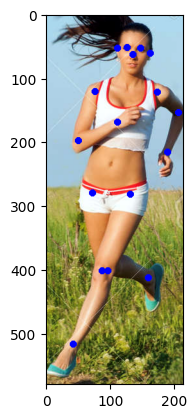

In [100]:
model_image_tensor_crop_255 = model_image_tensor_crop * 255
model_keypoints_crop = draw_keypoints(model_image_tensor_crop_255.to(torch.uint8), model_key_points_crop, colors = "blue", radius=5,)
plt.imshow(model_keypoints_crop.permute(1, 2, 0))

In [101]:
train_out1['boxes'][0]

tensor([364.4970,  47.4274, 596.7979, 392.8507], grad_fn=<SelectBackward0>)

In [102]:
train_image_tensor_crop1 = T.functional.crop(train_image_tensor1, int(train_out1['boxes'][0][1]), int(train_out1['boxes'][0][0]), int(train_out1['boxes'][0][3]\
                                                                                                                                      - train_out1['boxes'][0][1]),\

                                              int(train_out1['boxes'][0][2] - train_out1['boxes'][0][0]))

In [103]:
train_out1['boxes'][0][0]

tensor(364.4970, grad_fn=<SelectBackward0>)

In [104]:
train_key_points_crop_x1 = train_out1['keypoints'][0][:,0] - train_out1['boxes'][0][0]
train_key_points_crop_y1 = train_out1['keypoints'][0][:,1] - train_out1['boxes'][0][1]
train_key_points_crop1 = torch.ones((1, 17, 3))
train_key_points_crop1[0, :, 0] = train_key_points_crop_x1
train_key_points_crop1[0, :, 1] = train_key_points_crop_y1
train_key_points_crop1

tensor([[[ 58.2159,  30.0980,   1.0000],
         [ 62.7156,  23.3470,   1.0000],
         [ 58.7784,  23.9096,   1.0000],
         [ 82.4022,  25.5973,   1.0000],
         [ 86.3394,  25.0347,   1.0000],
         [ 90.8392,  51.4760,   1.0000],
         [103.2136,  50.3508,   1.0000],
         [ 45.2790,  91.4191,   1.0000],
         [153.2737,  63.2901,   1.0000],
         [ 12.6556,  63.8527,   1.0000],
         [169.0229, 111.1093,   1.0000],
         [117.8379, 166.8046,   1.0000],
         [ 86.9020, 165.6794,   1.0000],
         [152.7112, 236.5644,   1.0000],
         [ 33.4671, 213.4986,   1.0000],
         [207.2710, 309.1370,   1.0000],
         [ 54.2786, 298.4480,   1.0000]]], grad_fn=<CopySlices>)

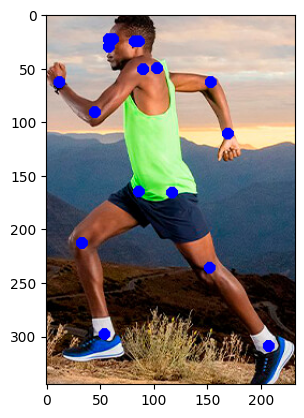

In [105]:
train_image_tensor_crop1_255 = train_image_tensor_crop1 * 255
train_keypoints_crop1 = draw_keypoints(train_image_tensor_crop1_255.to(torch.uint8), train_key_points_crop1, colors = "blue", radius=5,)
plt.imshow(train_keypoints_crop1.permute(1, 2, 0))

In [106]:
model_key_points_crop = model_key_points_crop[0][:,:2]
train_key_points_crop1 = train_key_points_crop1[0][:,:2]

In [107]:
model_key_points_crop

tensor([[135.4978,  63.6762],
        [147.6650,  53.7095],
        [126.6490,  52.6021],
        [162.0443,  61.4614],
        [111.1635,  53.7095],
        [173.1054, 122.3691],
        [ 76.8743, 121.2617],
        [206.2885, 154.4841],
        [ 50.3278, 198.7806],
        [189.6970, 216.4992],
        [111.1635, 169.9879],
        [131.0734, 282.9439],
        [ 72.4498, 280.7291],
        [ 87.9353, 402.5445],
        [ 96.7842, 402.5445],
        [ 42.5850, 517.7155],
        [159.8322, 413.6187]], grad_fn=<SliceBackward0>)

In [108]:
train_key_points_crop1

tensor([[ 58.2159,  30.0980],
        [ 62.7156,  23.3470],
        [ 58.7784,  23.9096],
        [ 82.4022,  25.5973],
        [ 86.3394,  25.0347],
        [ 90.8392,  51.4760],
        [103.2136,  50.3508],
        [ 45.2790,  91.4191],
        [153.2737,  63.2901],
        [ 12.6556,  63.8527],
        [169.0229, 111.1093],
        [117.8379, 166.8046],
        [ 86.9020, 165.6794],
        [152.7112, 236.5644],
        [ 33.4671, 213.4986],
        [207.2710, 309.1370],
        [ 54.2786, 298.4480]], grad_fn=<SliceBackward0>)

In [109]:
# pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
# unpad = lambda x: x[:, :-1]
Y = pad(model_key_points_crop.detach().numpy())
X = pad(train_key_points_crop1.detach().numpy())
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0
#transform_unpad = lambda x: unpad(np.dot(pad(x), A))
train_key_points_transform1_crop = transform_unpad(train_key_points_crop1.detach().numpy())

<ipython-input-109-93f5bea5d5c8>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


In [110]:
cd1_torch_crop = F.cosine_similarity(torch.tensor(train_key_points_transform1_crop), model_key_points_crop.detach(), dim=1)
print(cd1_torch_crop)
print(cd1_torch_crop.mean())

tensor([0.9966, 0.9917, 0.9967, 0.9851, 0.9961, 0.9915, 0.9722, 0.9776, 0.9453,
        0.9811, 0.9758, 0.9965, 0.9879, 0.9999, 0.9855, 1.0000, 0.9956],
       dtype=torch.float64)
tensor(0.9868, dtype=torch.float64)


In [111]:
cd1_torch1_crop = F.cosine_similarity(torch.tensor(train_key_points_transform1_crop), model_key_points_crop.detach(), dim=0)
print(cd1_torch1_crop)
print(cd1_torch1_crop.mean())

tensor([0.9674, 0.9899], dtype=torch.float64)
tensor(0.9786, dtype=torch.float64)


In [112]:
wd = weight_distance(train_key_points_transform1_crop, model_key_points_crop.detach().numpy(), train_out1["keypoints_scores"].detach().numpy()[0])

In [113]:
wd

array([27.20009752, 28.72895594])

Вектора считаются от левого верхнего угла изображения, поэтому угол любого вектора будет лежать в диапазоне от нуля до девяносто градусов. Попробуем еще немного разнести вектора, считая их координаты от центра изображения. И посмотрим, что получится.

In [114]:
model_key_points_crop.shape

torch.Size([17, 2])

In [115]:
h2_model = model_keypoints_crop.shape[1] / 2
w2_model = model_keypoints_crop.shape[2] / 2
h2_train = train_keypoints_crop1.shape[1] / 2
w2_train = train_keypoints_crop1.shape[2] / 2
model_key_points_crop_center = torch.zeros(model_key_points_crop.shape)
train_key_points_crop1_center = torch.zeros(train_key_points_crop1.shape)
model_key_points_crop_center[:, 0] = model_key_points_crop[:,0] - h2_model
model_key_points_crop_center[:, 1] = model_key_points_crop[:,1] - w2_model
train_key_points_crop1_center[:, 0] = train_key_points_crop1[:,0] - h2_train
train_key_points_crop1_center[:, 1] = train_key_points_crop1[:,1] - w2_train

In [116]:
model_key_points_crop_center

tensor([[-154.5022,  -43.8238],
        [-142.3350,  -53.7905],
        [-163.3510,  -54.8979],
        [-127.9557,  -46.0386],
        [-178.8365,  -53.7905],
        [-116.8946,   14.8691],
        [-213.1257,   13.7617],
        [ -83.7115,   46.9841],
        [-239.6722,   91.2806],
        [-100.3030,  108.9992],
        [-178.8365,   62.4879],
        [-158.9266,  175.4439],
        [-217.5502,  173.2291],
        [-202.0647,  295.0445],
        [-193.2158,  295.0445],
        [-247.4150,  410.2155],
        [-130.1678,  306.1187]], grad_fn=<CopySlices>)

In [117]:
train_key_points_crop1_center

tensor([[-114.2841,  -85.9020],
        [-109.7844,  -92.6530],
        [-113.7216,  -92.0904],
        [ -90.0978,  -90.4027],
        [ -86.1606,  -90.9653],
        [ -81.6608,  -64.5240],
        [ -69.2864,  -65.6492],
        [-127.2210,  -24.5809],
        [ -19.2263,  -52.7099],
        [-159.8444,  -52.1473],
        [  -3.4771,   -4.8907],
        [ -54.6621,   50.8046],
        [ -85.5980,   49.6794],
        [ -19.7888,  120.5644],
        [-139.0329,   97.4986],
        [  34.7710,  193.1370],
        [-118.2214,  182.4480]], grad_fn=<CopySlices>)

In [118]:
# pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
# unpad = lambda x: x[:, :-1]
Y = pad(model_key_points_crop_center.detach().numpy())
X = pad(train_key_points_crop1_center.detach().numpy())
A, res, rank, s = np.linalg.lstsq(X, Y)
A[np.abs(A) < 1e-10] = 0
#transform_unpad = lambda x: unpad(np.dot(pad(x), A))
train_key_points_transform1_crop_center = transform_unpad(train_key_points_crop1_center.detach().numpy())

<ipython-input-118-353b0ddb8810>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


In [119]:
cd1_torch_crop_center = F.cosine_similarity(torch.tensor(train_key_points_transform1_crop_center), model_key_points_crop_center.detach(), dim=1)
print(cd1_torch_crop_center)
print(cd1_torch_crop_center.mean())

tensor([0.9930, 0.9900, 0.9944, 0.9863, 0.9939, 0.9978, 0.9999, 0.9980, 0.9761,
        0.8161, 0.9947, 0.9979, 0.9900, 0.9993, 0.9978, 0.9998, 1.0000],
       dtype=torch.float64)
tensor(0.9838, dtype=torch.float64)


Косинусное расстояние стало чуть-чуть более вариативно.

In [120]:
cd1_torch1_crop_center = F.cosine_similarity(torch.tensor(train_key_points_transform1_crop_center), model_key_points_crop_center.detach(), dim=0)
print(cd1_torch1_crop_center)
print(cd1_torch1_crop_center.mean())

tensor([0.9816, 0.9791], dtype=torch.float64)
tensor(0.9804, dtype=torch.float64)


А вот по осям вроде как стало менее вариативно.

Проверим правильность пересчета координат, взвешенное расстояние не должно измениться.

In [121]:
wd_center = weight_distance(train_key_points_transform1_crop_center, model_key_points_crop_center.detach().numpy(), train_out1["keypoints_scores"].detach().numpy()[0])
wd_center

array([27.20009753, 28.72895669])

Взвешенное расстояние не изменилось, значит все правильно.

Обернем наши изыскания в классы

Класс для загрузки модели нейронной сети

In [2]:
class Model:
  def nn_model(self):
    model =  torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
    return model

Класс для обработки изображения и отрисовки результата

In [3]:
class FitImage:
  def __init__(self, image, model):
    self.image = image
    self.model = model
    transform = torchvision.transforms.Compose([T.ToTensor()])
    self.model_image_tensor = transform(self.image)
    model.eval()
    self.out = self.model([self.model_image_tensor])
    self.out = self.out[0]
    self.connect_skeleton = [
    (0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (6, 8),
    (7, 9), (8, 10), (5, 11), (6, 12), (11, 13), (12, 14), (13, 15), (14, 16)]

  def out_bboxes(self):
    boxes = np.zeros((1, 4))
    for i in range(len(self.out['boxes'])):
      if self.out['scores'][i] > 0.9:
        boxes = np.vstack((boxes, self.out['boxes'][i].detach().numpy()))
    boxes_tensor = torch.tensor(np.delete(boxes, 0, 0))
    return boxes_tensor

  def out_key_points(self):
    key_points = np.zeros((1, 17, 2))
    for i in range(len(self.out['boxes'])):
      if self.out['scores'][i] > 0.9:
        key_points[i] = self.out['keypoints'][i][:,:2].detach().numpy()
    key_points_tensor = torch.tensor(key_points)
    return key_points_tensor

  def out_keypoints_scores(self):
    out_kepoints_scores = np.zeros((1, 17))
    for i in range(len(self.out['boxes'])):
      if self.out['scores'][i] > 0.9:
        out_kepoints_scores = np.vstack((out_kepoints_scores, self.out['keypoints_scores'][i].detach().numpy()))
    out_kepoints_scores_tensor = torch.tensor(np.delete(out_kepoints_scores, 0, 0))
    return out_kepoints_scores_tensor

  def draw_bboxes(self, out_bboxes):
    image_255 = self.model_image_tensor * 255
    image = draw_bounding_boxes(image_255.to(torch.uint8), out_bboxes, colors = tuple(i*255//out_bboxes.shape[0] for i in range(out_bboxes.shape[0])), width=5)
    return image.permute(1, 2, 0)

  def draw_keypoints(self, out_key_points):
    image_255 = self.model_image_tensor * 255
    image = draw_keypoints(image_255.to(torch.uint8), out_key_points, colors = tuple(i*255//out_key_points.shape[0] for i in range(out_key_points.shape[0])), radius=5)
    return image.permute(1, 2, 0)

  def draw_skeleton(self, out_key_points):
    image_255 = self.model_image_tensor * 255
    model_skeleton = draw_keypoints(image_255.to(torch.uint8), out_key_points, connectivity=self.connect_skeleton, \
                                    colors = tuple(i*255//out_key_points.shape[0] for i in range(out_key_points.shape[0])), radius=5, width=3)
    return model_skeleton.permute(1, 2, 0)

  def crop_image(self, bboxes):
    list_image_crop = []
    for bbox in bboxes:
      image_crop = T.functional.crop(
          self.model_image_tensor, int(bbox[1]), int(bbox[0]), int(bbox[3] - bbox[1]), int(bbox[2] - bbox[0])
          )
      list_image_crop.append(image_crop)
    return list_image_crop

  def crop_key_points(self, crop_image, out_bboxes, out_key_points):

    self.data = zip(out_key_points, out_bboxes, crop_image)

    for key_point, bbox, image in self.data:

      key_points_crop_x = key_point[:,0] - bbox[0]
      key_points_crop_y = key_point[:,1] - bbox[1]
      key_points_crop = torch.ones((1, 17, 3))
      key_points_crop[0, :, 0] = key_points_crop_x
      key_points_crop[0, :, 1] = key_points_crop_y

      h2 = image.shape[1] / 2
      w2 = image.shape[2] / 2

      key_points_crop = key_points_crop[0][:, :2]

      key_points_crop_center = torch.zeros(key_points_crop.shape)

      key_points_crop_center[:, 0] = key_points_crop[:,0] - h2
      key_points_crop_center[:, 1] = key_points_crop[:,1] - w2


    return key_points_crop_center


Класс для вычисления метрик

In [18]:
class ScoreFit:
  def __init__(self, image_true, image_train):
    self.image_true = image_true
    self.image_train = image_train

  def aff_transform(self):
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]
    transform_unpad = lambda x: unpad(np.dot(pad(x), A))
    Y = pad(self.image_true.detach().numpy())
    X = pad(self.image_train.detach().numpy())
    A, res, rank, s = np.linalg.lstsq(X, Y)
    A[np.abs(A) < 1e-10] = 0
    key_points_transform = transform_unpad(self.image_train.detach().numpy())
    return key_points_transform

  def cos_distance(self, image_trans):

    cos_x = F.cosine_similarity(torch.tensor(image_trans), self.image_true.detach(), dim=1)
    cos_y = F.cosine_similarity(torch.tensor(image_trans), self.image_true.detach(), dim=0)
    return cos_x, cos_y

  def weight_distance(self, train_conf):

    self.train_conf = train_conf.detach().numpy()

    sum1 = 1 / np.sum(self.train_conf)
    sum2 = 0

    for i in range(len(self.image_train)):
        sum2 += train_conf[i] * abs(self.image_train[i] - self.image_true[i])
        weighted_dist = sum1 * sum2
    
    return weighted_dist


Загрузим модель

In [5]:
m = Model()
model = m.nn_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:07<00:00, 32.2MB/s]


Загрузим картинки

In [126]:
image_true = plt.imread('/content/dspr_cv_u1_diploma_spr1_3_1.png')
image_train = plt.imread('/content/runer_false.jpg')

In [127]:
image_true = image_true[...,:3]

Создадим объекты классов

In [128]:
image_true = FitImage(image_true, model)
image_train = FitImage(image_train, model)

Получим необходимые данные

In [129]:
out_bboxes_true = image_true.out_bboxes()
out_bboxes_train = image_train.out_bboxes()

In [130]:
out_key_points_true = image_true.out_key_points()
out_key_points_train = image_train.out_key_points()

In [131]:
ckpt_true = image_true.crop_key_points(image_true.crop_image(out_bboxes_true), out_bboxes_true, out_key_points_true)
ckpt_train = image_train.crop_key_points(image_train.crop_image(out_bboxes_train), out_bboxes_train, out_key_points_train)

In [132]:
ckpt_true

tensor([[-154.5022,  -43.8238],
        [-142.3350,  -53.7905],
        [-163.3510,  -54.8979],
        [-127.9557,  -46.0386],
        [-178.8365,  -53.7905],
        [-116.8946,   14.8691],
        [-213.1257,   13.7617],
        [ -83.7115,   46.9841],
        [-239.6722,   91.2806],
        [-100.3030,  108.9992],
        [-178.8365,   62.4879],
        [-158.9266,  175.4439],
        [-217.5502,  173.2291],
        [-202.0647,  295.0445],
        [-193.2158,  295.0445],
        [-247.4150,  410.2155],
        [-130.1678,  306.1187]])

In [133]:
ckpt_train

tensor([[-143.5442,   -9.4211],
        [-131.2937,  -22.3776],
        [-155.7947,  -21.6577],
        [-110.3958,  -29.5756],
        [-172.3689,  -29.5756],
        [ -79.4093,  -22.3776],
        [-204.7966,   -3.6627],
        [ -49.8640,  -79.2420],
        [-307.1243,   11.4532],
        [  -7.3475, -127.4688],
        [-227.8564,  -69.1647],
        [-103.1896,  153.9742],
        [-182.4575,  169.8098],
        [-101.7484,  220.1961],
        [-178.1338,  326.0070],
        [-135.6174,  410.9438],
        [-172.3689,  417.4220]])

Вычислим метрики

In [134]:
score_fit = ScoreFit(ckpt_true, ckpt_train)

Косинусное расстояние

In [135]:
score_fit.cos_distance(score_fit.aff_transform())

<ipython-input-124-8f830c2f37d5>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


(tensor([0.6415, 0.6712, 0.6632, 0.7450, 0.7179, 0.9613, 0.7490, 0.8416, 0.6144,
         0.3610, 0.9348, 0.9617, 0.8387, 0.9743, 0.9351, 0.9484, 0.9774],
        dtype=torch.float64),
 tensor([0.8787, 0.9216], dtype=torch.float64))

Взвешенное расстояние

In [137]:
score_fit.weight_distance(image_train.out_keypoints_scores()[0])

tensor([37.8447, 53.0311])

Возьмем из тестового видео нужные нам пять секунд

In [148]:

count = 1
videoFile = "/content/down.mp4"
cap = cv2.VideoCapture(videoFile)   # загрузка видео
frameRate = cap.get(5) # частота кадров

while(cap.isOpened() and count <151):
  frameId = cap.get(1) # номер текущего кадра
  ret, frame = cap.read()
  if (ret != True):
      break
  elif (frameId > 1169) and (frameId < 1320): #(frameId % math.floor(frameRate) == 0)
    filename ="video1/frame%d.jpg" % count;count+=1
    cv2.imwrite(filename, frame)

cap.release()

In [151]:
frameSize = (1280, 720)
out = cv2.VideoWriter('output_video.avi',cv2.VideoWriter_fourcc(*'DIVX'), frameRate, frameSize)
for i in range(1, 151):
  img = cv2.imread("video/frame%d.jpg" % i)
  out.write(img)
out.release()

Сравним два видео между собой

In [32]:
count = 1
videoFile1 = "/content/output_video.avi"
videoFile2 = "/content/lena1.mp4"
cap1 = cv2.VideoCapture(videoFile1)   # загрузка видео
cap2 = cv2.VideoCapture(videoFile2)
frameRate1 = cap1.get(5) # частота кадров
frameRate2 = cap2.get(5)

frameRate = frameRate1 if frameRate1 <= frameRate2 else frameRate2

while(cap1.isOpened() and cap2.isOpened()):
  frameId1 = cap1.get(1) # номер текущего кадра
  ret1, frame1 = cap1.read()

  frameId2 = cap2.get(1) # номер текущего кадра
  ret2, frame2 = cap2.read()

  if (ret1 != True) or (ret2 != True):
      break
  else:

    image1 = FitImage(frame1, model)
    out_bboxes1 = image1.out_bboxes()
    out_key_points1 = image1.out_key_points()
    ckpt1 = image1.crop_key_points(image1.crop_image(out_bboxes1), out_bboxes1, out_key_points1)

    image2 = FitImage(frame2, model)
    out_bboxes2 = image2.out_bboxes()
    out_key_points2 = image2.out_key_points()
    ckpt2 = image2.crop_key_points(image2.crop_image(out_bboxes2), out_bboxes2, out_key_points2)

    image_out1 = image1.draw_skeleton(out_key_points1)
    image_out2 = image2.draw_skeleton(out_key_points2)

    score_fit = ScoreFit(ckpt1, ckpt2)

    cos_x, cos_y = score_fit.cos_distance(score_fit.aff_transform())

    cos_res =(np.mean(cos_x.detach().numpy()) + np.mean(cos_y.detach().numpy())) / 2

    weight_distance = score_fit.weight_distance(image2.out_keypoints_scores()[0])
    weight_distance_res = np.mean(weight_distance.detach().numpy())

    image = np.zeros((1480, 1280, 3))

    image[:720, :, :] = image_out1.detach().numpy()
    image[720:1440, :, :] = image_out2.detach().numpy()


    text = f"Cosinus: {cos_res}    Distance: {weight_distance_res}"
    image = cv2.putText(image, text, (20,1470), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)



    filename ="video_out/frame%d.jpg" % count;count+=1
    cv2.imwrite(filename, image)

cap1.release()
cap2.release()

<ipython-input-18-933c2ffee760>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, res, rank, s = np.linalg.lstsq(X, Y)


Соберем результат в итоговый видеофайл

In [39]:
frameSize = (1280, 720)
out = cv2.VideoWriter('video_out.avi',cv2.VideoWriter_fourcc(*'DIVX'), frameRate, frameSize)
for i in range(1, count):
  img = cv2.imread("video_out/frame%d.jpg" % i)
  resized = cv2.resize(img, frameSize, interpolation = cv2.INTER_AREA)
  out.write(resized)
out.release()